# Deconvolution with FRC and a single image

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

In [58]:
%matplotlib inline

import os
import numpy as np

from supertomo.data.io import carma
import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.wrappers import image_writer_wrappers as imwrap



Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [59]:
# Image
data_dir = "/Users/sami/Temp"
filename = "20170120_122128_781.mat"
full_path = os.path.join(data_dir, filename)

data = carma.read_carma_mat(full_path)

print "The Carma file {} contains images from {} laser gates and {} detector channels.".format(
    filename, data.ngates, data.ndetectors)

image = data[0,0]
image_copy = image.astype(np.uint8).copy()
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)


The Carma file 20170120_122128_781.mat contains images from 1 laser gates and 1 detector channels.
The image dimensions are (500, 500) and spacing [0.040080160320641281, 0.040080160320641281] um.


In [60]:
from supertomo.data.containers.image import Image

def get_confocal_psf(ndim, ex_wavelen=633, em_wavelen=660, na=1.4, refr_index=1.51, 
                     pinhole=1.4, magnification=100, sted=False):

    psf = psfgen.PSF(psfgen.GAUSSIAN | psfgen.CONFOCAL, shape=(128,128), ex_wavelen=ex_wavelen, 
                          em_wavelen=em_wavelen, num_aperture=na, refr_index=refr_index, 
                          pinhole_radius=pinhole, magnification=magnification )
    if sted:
        psf.sted_correction()
        
    psf_image = psf.volume()
    psf_spacing = (psf.dims['um'][0]/psf.shape[0],)*3

    if ndim == 2:
        psf_image = psf_image[psf_image.shape[0]/2]
        psf_spacing = psf_spacing[:-1]

    return Image(psf_image, psf_spacing)

psf = get_confocal_psf(2)

print "Succesfully generated a theoretical PSF."
print "The image dimensions are {} and spacing {}.".format(psf.shape, psf.spacing)

Succesfully generated a theoretical PSF.
The image dimensions are (255, 255) and spacing [0.03125, 0.03125].


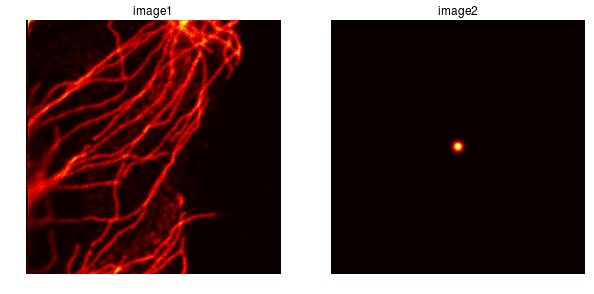

In [61]:
showim.display_2d_images(image, psf)

Run deconvolution

In [62]:
from supertomo.ui import deconvolution_options as options
n_iterations = 60
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=half-bit").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [63]:

writer = imwrap.TiffImageWriter(data_dir)

#from scipy.ndimage import gaussian_filter
#image = Image(gaussian_filter(image, 1), image.spacing)
task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

The original image size is (500, 500)
The deconvolution will be run with 1 blocks
The internal block size is (500, 500)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/60                ] E/S/U/N=0/977207/1569148/0, LEAK=-1.82873494126e-08%, TAU1=0.077331610024, TIME=0.129s, U/ESU=0.616 
Beginning the computation of the 1. estimate
[>                 2/60                ] ETA:6.1s E/S/U/N=0/1586953/959402/0, LEAK=4.983813362e-09%, TAU1=0.0467792488635, TIME=9.77E-2s, U/ESU=0.377 
Beginning the computation of the 2. estimate
[=>                3/60                ] ETA:5.9s E/S/U/N=0/2039755/506600/0, LEAK=-2.02290406648e-08%, TAU1=0.0338498055935, TIME=9.65E-2s, U/ESU=0.199 
Beginning the computation of the 3. estimate
[==>               4/60                ] ETA:5.6s E/S/U/N=0/2267669/278686/0, LEAK=-4.39892566817e-09%, TAU1=0.0265790782869, TIME=9.31E-2s, U/ESU=0.109 
Beginning the computation of the 4. estimate
[==>               5/60       

[=================41/60===>            ] ETA:1.8s E/S/U/N=0/2544410/1945/0, LEAK=-6.71023236976e-09%, TAU1=0.00322102592327, TIME=9.00E-2s, U/ESU=7.64E-4 
Beginning the computation of the 41. estimate
[=================42/60====>           ] ETA:1.7s E/S/U/N=2/2544523/1830/0, LEAK=-7.07627290097e-09%, TAU1=0.00315829575993, TIME=9.60E-2s, U/ESU=7.19E-4 
Beginning the computation of the 42. estimate
[=================43/60====>           ] ETA:1.6s E/S/U/N=0/2544638/1717/0, LEAK=-1.93358662415e-08%, TAU1=0.00309856701642, TIME=8.66E-2s, U/ESU=6.75E-4 
Beginning the computation of the 43. estimate
[=================44/60=====>          ] ETA:1.5s E/S/U/N=55/2544696/1604/0, LEAK=1.05797814953e-08%, TAU1=0.00304164248519, TIME=0.100s, U/ESU=6.30E-4 
Beginning the computation of the 44. estimate
[=================45/60======>         ] ETA:1.4s E/S/U/N=54/2544790/1510/0, LEAK=-8.16702261375e-09%, TAU1=0.00298729306087, TIME=8.98E-2s, U/ESU=5.93E-4 
Beginning the computation of the 45. estim

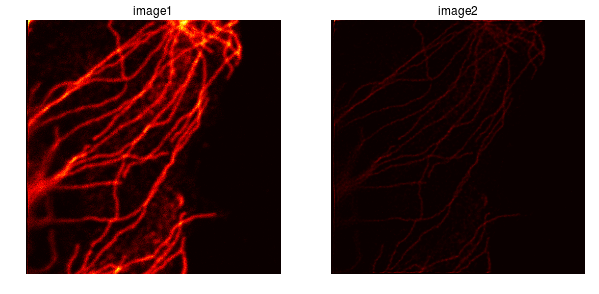

In [64]:
result = task.get_8bit_result()

showim.display_2d_images(image, result)



Show resolution curve

In [65]:
import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image_path = os.path.join(data_dir, image_name)

    image = read.get_image(image_path)
    image1, image2 = imops.checkerboard_split(image)
    
    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0]*sqrt(2), args)
results = analyzer.execute()


Fit starts at 0.680000007153
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.680000007153
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.680000007153
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.680000007153
Optimization terminated successfully.
         Current function value: 0.000042
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.680000007153
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.680000007153
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 10
         Function evaluations: 2

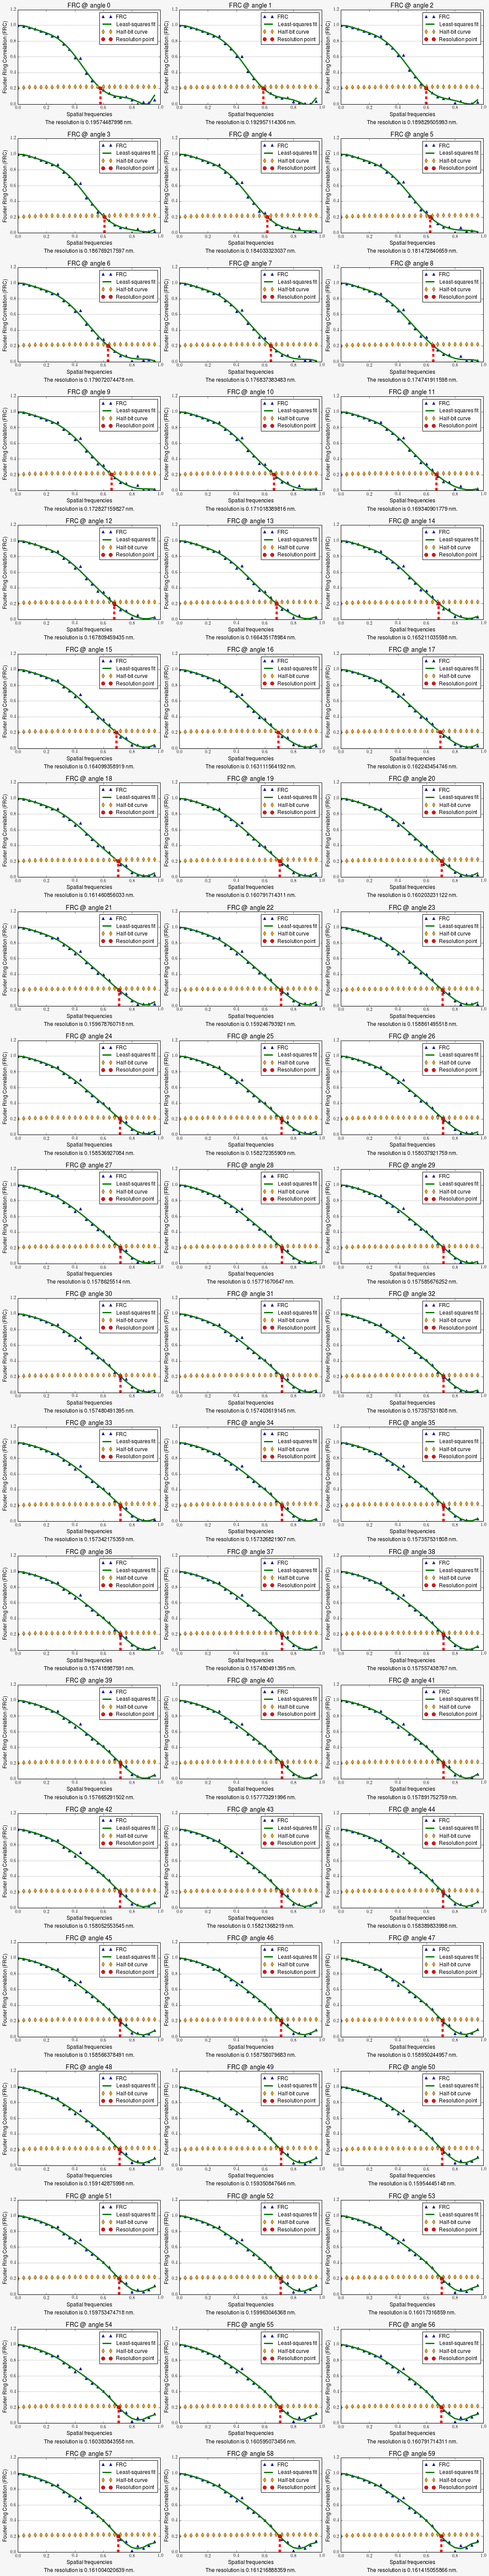

In [66]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

## Regarding the measured FRC values

I wanted to see look more closely into how the FRC values behave as a function of the iteration count. The *SuperTomo* deconvolution algorithm also calculates several parameter values that have traditionally been used to evaluate the progress of an iterative deconvolution. For more info, look at (Koho et al 2014). 

Here I normalize all the parameter values (0-1) for easy comparison and plotting. The original values are maintained in the *deconvolution_parameters* dataframe.

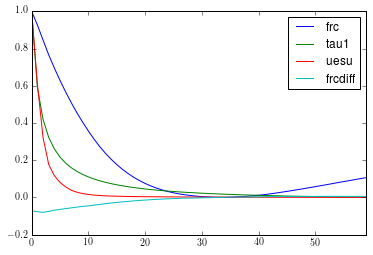

In [67]:
# Get a list of the resolution values as a function of iteration number
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.append(dataset[1].resolution["resolution"])

iterations, resolutions = zip(*sorted(zip(iterations, resolutions)))

# Get saved deconvolution parameters
deconvolution_parameters = task.progress_parameters
deconvolution_parameters['frc'] = resolutions


# Set up curves
curves = deconvolution_parameters.loc[:, ['frc', 'tau1', 'uesu']]

curves['frc'] -= curves['frc'].min()
curves['frc'] /= curves['frc'].max()

curves['tau1'] -= curves['tau1'].min()
curves['tau1'] /= curves['tau1'].max()

curves['uesu'] -= curves['uesu'].min()
curves['uesu'] /= curves['uesu'].max() 

curves['frcdiff'] = np.gradient(curves['frc'])



curves.plot()

## Regarding the FRC resolution curve

The FRC resolution value curve behaves in a very interestin way. It is first of all much more linear than *u_esu* and *tau1* and what is quite extraordinary,  the FRC value is able to discern the iteration after which the RL algorithm stops fitting the data, and mainly starts amplifying the noise.

In [68]:
zero_crossing = int(np.where(np.diff(np.sign(curves['frcdiff'])))[0])

print "The deconvolution should be stopped at iteration {}.".format(zero_crossing)

The deconvolution should be stopped at iteration 33.


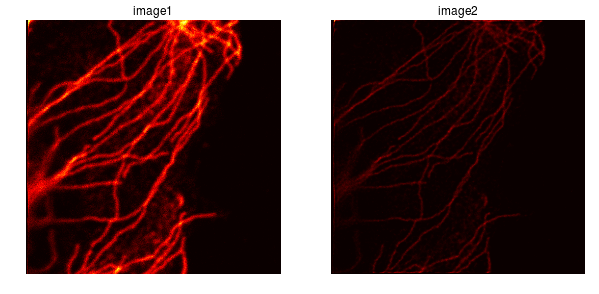

In [69]:
image_path = os.path.join(data_dir, "result_33.tif")

result_image = read.get_image(image_path)
result_image *= 255/result_image.max()

showim.display_2d_images(image_copy, result_image)


